# Report
#### Boyun Huang (z5342276)

#### Technical Process of ML Model
1. Replaced all cells of NaN value by string or numerical value due to column type for both datasets
2. Ecode all object columns' value to numerical value for both datasets
3. Filtered by variance value for the train set to reduce train data's dimension (filer some columns)
4. Set top k relevant features for train set and standardize the column just in case the values in same column are too different
5. Construct the model of the train set for the use of the test dataset to make the prediction

####  Data Preprocessing
1. Replacement of NaN value
For the training csv file, many cells are float with 'NaN' values, and this will cause problems when do the calculation or aggregation for the train data. Thus, the first step is filling all 'Nan' cells with 'unknown' if the column's type belongs to object. If the column's type is numerical, I fill all 'Nan' cells with the mean value of the column. If no 'Nan' value in the coluwn, do nothing with this column.
2. LabelEncoder
Inorder to evaluate the whole data without removing columns casually, using 'from sklearn.preprocessing import LabelEncoder' to convert all string value of cells to numerical value. Then all the data of cells can be calculated. I don't choose the other enoding way like 'onehot', it just separate from one object column to several numerical columns to construct the similar binary format, which makes the problem complicated. 'LabelEncoder' is the most direct way for this part.

In [65]:
import pandas as pd, warnings
import matplotlib.pylab as plt, seaborn as sns
from copy import deepcopy
warnings.filterwarnings('ignore')
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_regression, VarianceThreshold
from sklearn.linear_model import SGDRegressor
# Data Preprocessing
def preprocessing_data(data):
    # replacemnent of NaN
    for col in data.columns:
        if str(data[col].dtypes) == 'object':
            data[col].fillna('unknown', inplace=True)
        else:
            data[col].fillna(data[col].mean(), inplace=True)

    #Lable Encoding
    for i in range(data.shape[1]):
        if type(data.iat[0,i]) == str:
            data[list(data.columns)[i]] = LabelEncoder().fit_transform(\
                data[list(data.columns)[i]].astype('str'))
    preprocessing_data = data
    return preprocessing_data

train_set = pd.read_csv('training.csv')
test_set = pd.read_csv('test.csv')
train_set = preprocessing_data(train_set)
print('train_set\'s shape: ', train_set.shape)

train_set's shape:  (108000, 122)


3. Filtering Low Variance Column
Using VarianceThreshold() to remove the training-set's columns with lower-variance value to
reduce data set further. To guarantee the data preserved in the set are more relevant.

In [66]:
low_var_colunms = train_set.columns[VarianceThreshold(threshold=0.025)\
                  .fit(train_set).get_support()]
low_var_set = train_set[low_var_colunms]
print('low_var_set\'s shape: ', low_var_set.shape) # some columns have been removed

low_var_set's shape:  (108000, 55)


Using get_support() to separate from original dataset to normal columns and low-variance columns. Choosing the boolean True value as the normal columns we want to preserve.

In [67]:
col = VarianceThreshold(threshold=0.025)
VT = pd.DataFrame(train_set.columns.tolist())
VT.rename(columns = {0:'column names'}, inplace = True)
col.fit(train_set)
VT['get_support_bool'] = col.get_support()
VT

,column names,get_support_bool
0,SK_ID_CURR,True
1,TARGET,True
2,NAME_CONTRACT_TYPE,True
3,CODE_GENDER,True
4,FLAG_OWN_CAR,True
...,...,...
117,AMT_REQ_CREDIT_BUREAU_DAY,False
118,AMT_REQ_CREDIT_BUREAU_WEEK,True
119,AMT_REQ_CREDIT_BUREAU_MON,True
120,AMT_REQ_CREDIT_BUREAU_QRT,True


4. Standardize the dataset columns
Using MinMaxScaler() to normalize the column according to the minimum and maximum value of the column just in case the values in same column are too different. After scaling, $X\ becomes\ \tilde{X}.$
$$ \tilde{X}: = \frac{X-\min(X)}{\max(X)-min(X)} $$

In [68]:
# retrieve from: https://www.datatrigger.org/post/scaling/
train_set_Y = low_var_set['AMT_INCOME_TOTAL']
corr_set = deepcopy(low_var_set)
train_set_X = low_var_set.drop('AMT_INCOME_TOTAL', axis=1)
#select 32 best relevant features
feature_columns = train_set_X.columns[SelectKBest(score_func=f_regression, k=32).\
    fit(train_set_X, train_set_Y).get_support()]
# standardize
standardize = MinMaxScaler(feature_range=(0,1), copy=True, clip=False)
train_set_X = standardize.fit(train_set_X[feature_columns].values).\
              transform(train_set_X[feature_columns].values)
# generate regression model
model = SGDRegressor()
model.fit(train_set_X, train_set_Y)
test_set = preprocessing_data(test_set)
test_set_Y = test_set['AMT_INCOME_TOTAL']
test_set_X = standardize.transform(test_set[feature_columns].values)
# use constructed model to make prediction
predict_test_Y = model.predict(test_set_X)
MSE = mean_squared_error(test_set_Y, predict_test_Y)
corr = pearsonr(test_set_Y, predict_test_Y)[0]

Regression Part

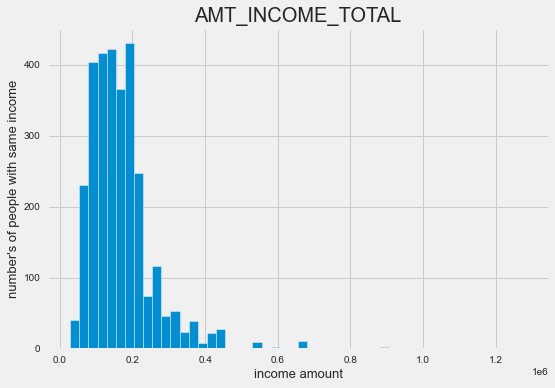

In [69]:
plt.hist(train_set.AMT_INCOME_TOTAL.tolist()[:3000], bins=50)
plt.style.use('seaborn')
plt.title('AMT_INCOME_TOTAL', fontsize = 20)
plt.xlabel('income amount', fontsize = 13)
plt.ylabel('number\'s of people with same income', fontsize = 13)
plt.show()

I can't plot 100000+ datas in figure to make the distribution vague. Instead of ploting all datas, I just plot the first 3000 data to roughly estimate the range of income orders. The range is large, and some differences between two income values are too big. Therefore, it's necessary to use standardscaler() for eliminating the difference of value in the same column to some extent.

Check feature_columns with 'AMT_INCOME_TOTAL'

In [70]:
feature_columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'OWN_CAR_AGE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_8', 'AMT_REQ_CREDIT_BUREAU_MON'],
      dtype='object')

<AxesSubplot:>

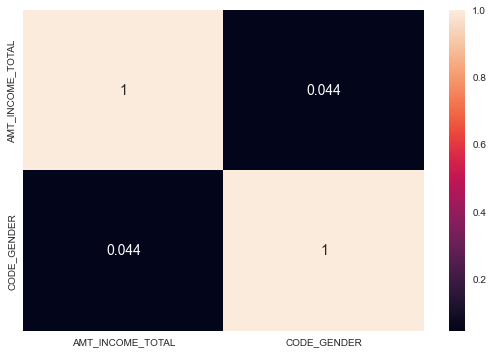

In [71]:
sns.heatmap(corr_set[['AMT_INCOME_TOTAL','CODE_GENDER']].corr(), annot=True)

<AxesSubplot:>

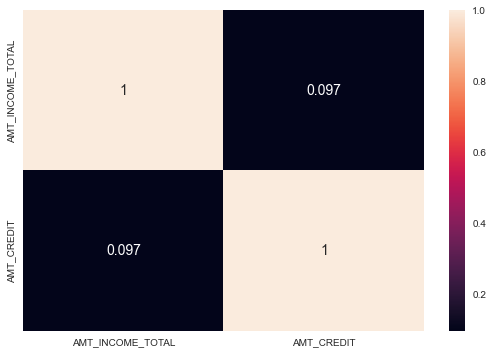

In [72]:
sns.heatmap(corr_set[['AMT_INCOME_TOTAL','AMT_CREDIT']].corr(), annot=True)

<AxesSubplot:>

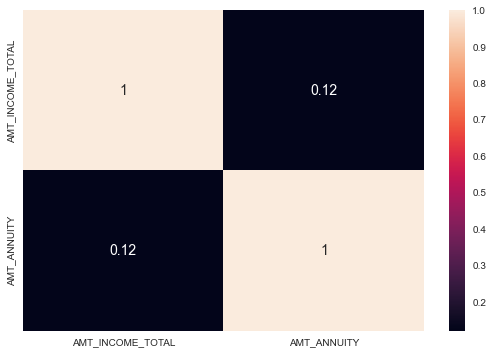

In [73]:
sns.heatmap(corr_set[['AMT_INCOME_TOTAL','AMT_ANNUITY']].corr(), annot=True)

<AxesSubplot:>

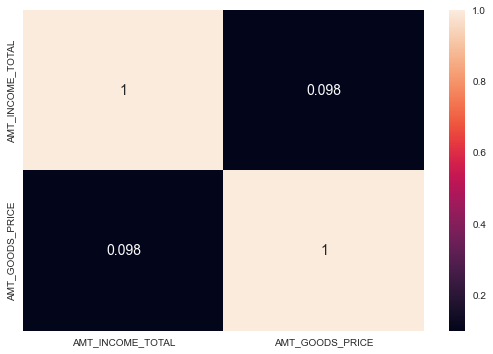

In [74]:
sns.heatmap(corr_set[['AMT_INCOME_TOTAL','AMT_GOODS_PRICE']].corr(), annot=True)

<AxesSubplot:>

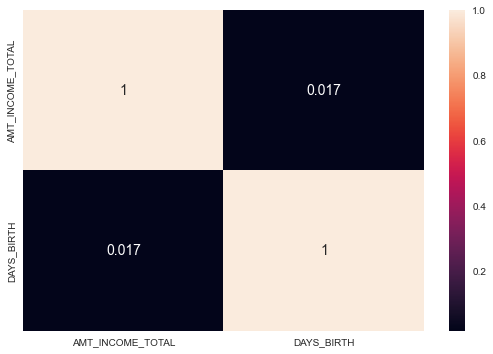

In [75]:
sns.heatmap(corr_set[['AMT_INCOME_TOTAL','DAYS_BIRTH']].corr(), annot=True)

Randomly choosing from feature columns, it can be noticed that correlations are positive with 'AMT_INCOME_TOTAL', which means the feature_columns are correct.

Classification Part

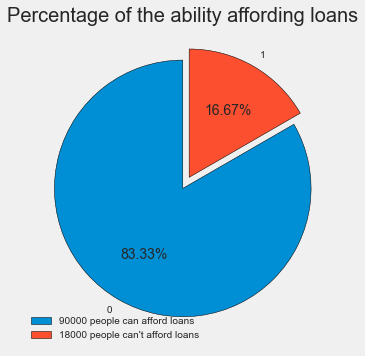

In [76]:
plt.style.use('fivethirtyeight')
slice = [corr_set.TARGET.value_counts()[0],corr_set.TARGET.value_counts()[1]]
explode = [0,0.1]
label=['0','1']
plt.pie(slice, labels=label, explode=explode, startangle=90, autopct = '%1.2f%%',\
        wedgeprops={'edgecolor':'black'})
plt.title('Percentage of the ability affording loans', fontsize=20)
plt.legend([str(corr_set.TARGET.value_counts()[0])+' people can afford loans', \
            str(corr_set.TARGET.value_counts()[1])+' people can\'t afford loans']\
           , loc='best')
plt.show()

It can be roughly known the percentage of '0' and '1' and their quantities from the pie chart, then I can choose a appropriate model to predict the 'TARGET'.

Reference List
    https://www.datatrigger.org/post/scaling/